# Imports

In [ ]:
pip install tensorflowjs

In [ ]:
import numpy as np 
import tensorflow as tf
import sklearn
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
import tensorflowjs as tfjs

# Set Hyperparameters:

Epochs

*   Epochs
*   INput Path
*   Output Path model
*   Output Path predictions
*   Path to segmentation model to load

In [ ]:
base_area_path = '/content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/data/disease'
base_image_path = '/content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/data/disease/images'


label_to_word = {0:'healthy', 1:'multiple_diseases', 2:'rust', 3:'scab'}

IMG_HEIGHT, IMG_WIDTH = 224, 224

BATCH_SIZE = 32
SEED = 124
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = 4

NORMALIZE = True

EPOCHS = 30

# Data Preparation

In [ ]:
df = pd.read_csv(base_area_path + '/train.csv')


train_df,val_df=train_test_split(df,test_size=0.2,shuffle=True,random_state=23,stratify=df.iloc[:,1:])


test_df = pd.read_csv(base_area_path + '/test.csv')


In [ ]:
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)

In [ ]:
@tf.function
def load_image_train(image, label) -> tuple:
    """Apply some transformations to an input dictionary
    containing a train image and its annotation.

    Notes
    -----
    An annotation is a regular  channel image.
    If a transformation such as rotation is applied to the image,
    the same transformation has to be applied on the annotation also.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """

    input_image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    # input_image = tf.image.resize_with_pad(image, IMG_HEIGHT, IMG_WIDTH)

    if tf.random.uniform(()) > 0.5:
      input_image = tf.image.flip_left_right(input_image)
    
    if tf.random.uniform(()) > 0.5:
      # input_image = tf.image.random_hue(input_image, 0.08)
      # input_image = tf.image.random_saturation(input_image, 0.6, 1.6)
      input_image = tf.image.random_brightness(input_image, 0.05)
      # input_image = tf.image.random_contrast(input_image, 0.7, 1.3)
      input_image = tf.image.random_contrast(input_image, 0.7, 0.9)

    normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

    # input_image= normalization_layer(input_image)

    return input_image, label

@tf.function
def load_image_test(image) -> tuple:
    """Normalize and resize a test image and its annotation.

    Notes
    -----
    Since this is for the test set, we don't need to apply
    any data augmentation technique.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    
    input_image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    # input_image = tf.image.resize_with_pad(image, IMG_HEIGHT, IMG_WIDTH)
    

    normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
    # input_image= normalization_layer(input_image)


    return input_image

@tf.function
def normalize(image) -> tuple:
  normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
  return normalization_layer(image)



def parse_image(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    image = tf.io.read_file(img_path)
    # jpg in test instead
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # For one Image path:
    # .../trainset/images/training/ADE_train_00000001.jpg
    # Its corresponding annotation path is:
    # .../trainset/mask/training/ADE_train_00000001.png
    mask_path = tf.strings.regex_replace(img_path, "image", "mask")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    mask = tf.io.read_file(mask_path)
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)



    return image


def combine(label, image):

  return image, label


In [ ]:
def process_df(df, is_test=False):

  if is_test:
    paths = df['image_id'].map(lambda x: f'{base_image_path}/{x}.jpg')
    images = tf.data.Dataset.from_tensor_slices(paths).map(parse_image)
    return images.map(load_image_test)

  else:
    paths = df['image_id'].map(lambda x: f'{base_image_path}/{x}.jpg')

    labels = tf.data.Dataset.from_tensor_slices(np.argmax(df.iloc[:,1:].values, axis=1))

    images = tf.data.Dataset.from_tensor_slices(paths).map(parse_image)

    output = tf.data.Dataset.zip((images, labels))

    output = output.map(load_image_train)

  # data = output.map(parse_image)
  return output

healthy


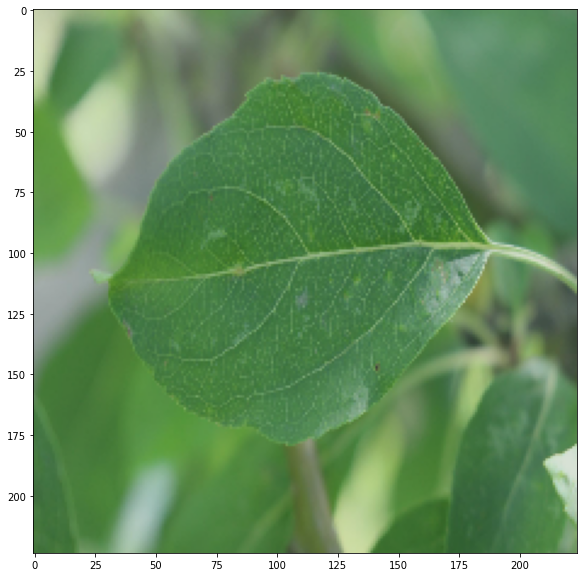

In [ ]:
train_data = process_df(train_df)

plt.figure(figsize=(10, 10))

for image, label in train_data.shuffle(10).take(1):
  print(label_to_word[label.numpy()])
  
  plt.imshow(image.numpy().astype("uint8"))

In [ ]:
test_data = process_df(test_df, True)

In [ ]:
val_data = process_df(val_df)

## optimize

In [ ]:
train_data_batched  = train_data.batch(BATCH_SIZE).cache().shuffle(SEED).prefetch(buffer_size=AUTOTUNE)
test_data_batched = test_data.batch(BATCH_SIZE).cache().shuffle(SEED).prefetch(buffer_size=AUTOTUNE)
val_data_batched = val_data.batch(BATCH_SIZE).cache().shuffle(SEED).prefetch(buffer_size=AUTOTUNE)

In [ ]:
if NORMALIZE:
  train_data_batched = train_data_batched.map(lambda x, y: (normalize(x), y))
  val_data_batched = val_data_batched.map(lambda x, y: (normalize(x), y))
  print('normalized')

normalized


In [ ]:
# for image_batch, labels_batch in train_data_batched.take(1):
#   first_image = image_batch[0]
#   # pixels values are now in `[0,1]`.
#   print(np.min(first_image), np.max(first_image))

# Model Architecture

In [ ]:
# feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
# # feature_extractor_model = "https://tfhub.dev/tensorflow/efficientnet/b7/classification/1"

# feature_extractor_layer = hub.KerasLayer(
#     feature_extractor_model, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), trainable=False)

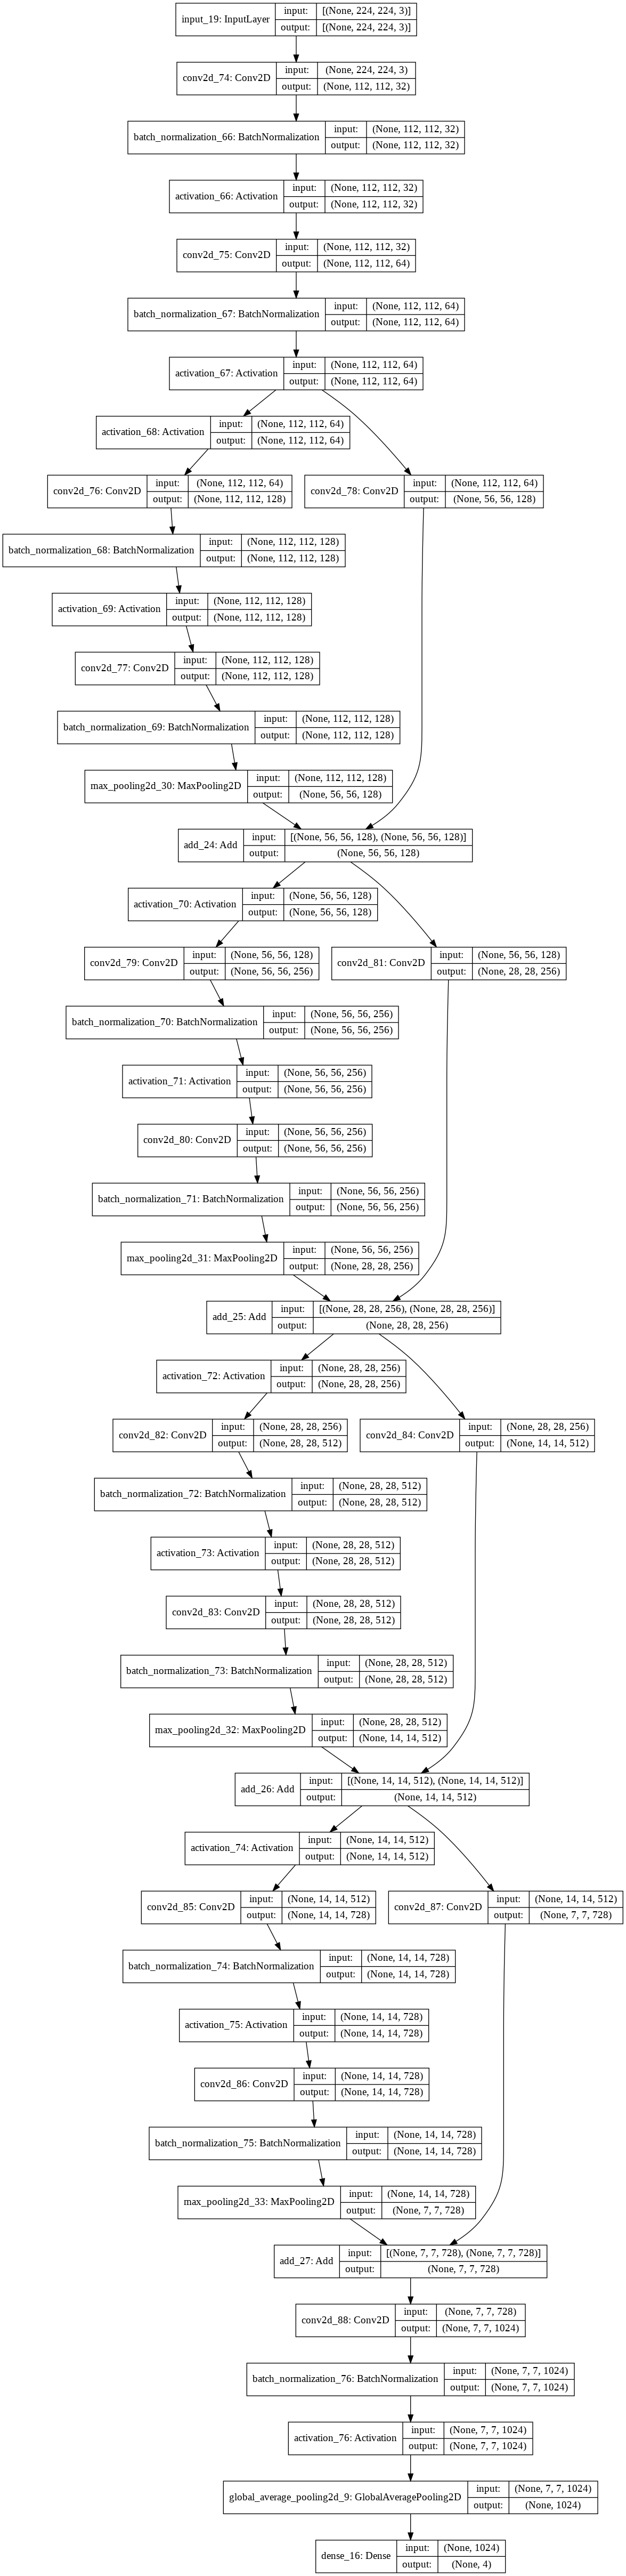

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.Conv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    # x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=4)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# num_classes = NUM_CLASSES

# # input to efficient net IS NOT NORMALIZED
# # base_model = tf.keras.applications.EfficientNetB7(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')

# base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')

# base_model.trainable = False
# model = base_model
# model = tf.keras.Sequential([
#   base_model,
#   tf.keras.layers.MaxPool2D(3,3),
#   # tf.keras.layers.Dropout(0.5),
#   # tf.keras.layers.Dropout(0.5),
#   tf.keras.layers.Flatten(),
#   # tf.keras.layers.GlobalAveragePooling2D(),
#   # # tf.keras.layers.ReLU(),
#   tf.keras.layers.Dropout(0.5),
#   tf.keras.layers.Dense(num_classes),
#   # tf.keras.layers.Dropout(0.5)
# ])

# model.summary()

In [ ]:
# tf.keras.utils.plot_model(model)

In [ ]:
for image_batch, labels in val_data_batched.take(1):
  predictions = model(image_batch)
  print(predictions.shape)

(32, 4)


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(0.0005),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

# Model Training

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    self.val_losses = []
    self.val_acc = []

  # def on_train_batch_end(self, batch, logs=None):
  #   self.batch_losses.append(logs['loss'])
  #   # self.batch_acc.append(logs['val_acc'])
  #   # self.val_losses.append(logs['val_loss'])
  #   self.val_acc.append(logs['acc'])
  #   self.model.reset_metrics()

  def on_epoch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.val_losses.append(logs['val_loss'])
    self.val_acc.append(logs['val_acc'])
    self.model.reset_metrics()


def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  elif epoch == 10:
    return lr / 2
  elif epoch == 20:
    return lr / 2
  elif epoch == 25:
    return lr / 5
  return lr

schedule_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

batch_stats_callback = CollectBatchStats()

history = model.fit(train_data_batched, epochs=20, validation_data=val_data_batched,
                    callbacks=[batch_stats_callback])


Epoch 1/20
46/46 [==============================] - 16s 354ms/step - loss: 0.2536 - acc: 0.9100 - val_loss: 1.8093 - val_acc: 0.6082
Epoch 2/20
46/46 [==============================] - 16s 359ms/step - loss: 0.2286 - acc: 0.9217 - val_loss: 3.3391 - val_acc: 0.5151
Epoch 3/20
46/46 [==============================] - 17s 362ms/step - loss: 0.1890 - acc: 0.9396 - val_loss: 0.9880 - val_acc: 0.6740
Epoch 4/20
46/46 [==============================] - 17s 362ms/step - loss: 0.1631 - acc: 0.9416 - val_loss: 0.7643 - val_acc: 0.8301
Epoch 5/20
46/46 [==============================] - 17s 361ms/step - loss: 0.1566 - acc: 0.9451 - val_loss: 1.2031 - val_acc: 0.7562
Epoch 6/20
46/46 [==============================] - 17s 360ms/step - loss: 0.1191 - acc: 0.9602 - val_loss: 1.7152 - val_acc: 0.6877
Epoch 7/20
46/46 [==============================] - 17s 360ms/step - loss: 0.1262 - acc: 0.9581 - val_loss: 0.5821 - val_acc: 0.8164
Epoch 8/20
46/46 [==============================] - 17s 361ms/step - 

KeyboardInterrupt: ignored

In [ ]:
model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

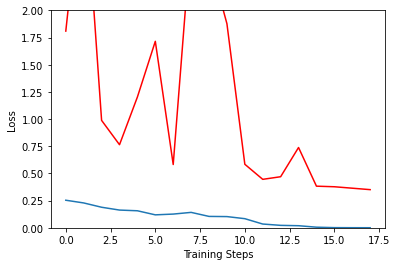

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)
plt.plot(batch_stats_callback.val_losses, 'r-')

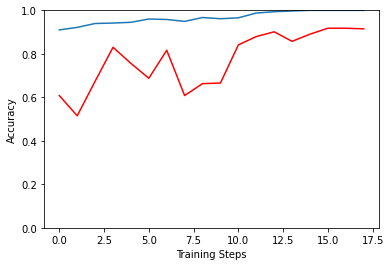

In [ ]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)
plt.plot(batch_stats_callback.val_acc, 'r-')

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = [label_to_word[x] for x in predicted_id]

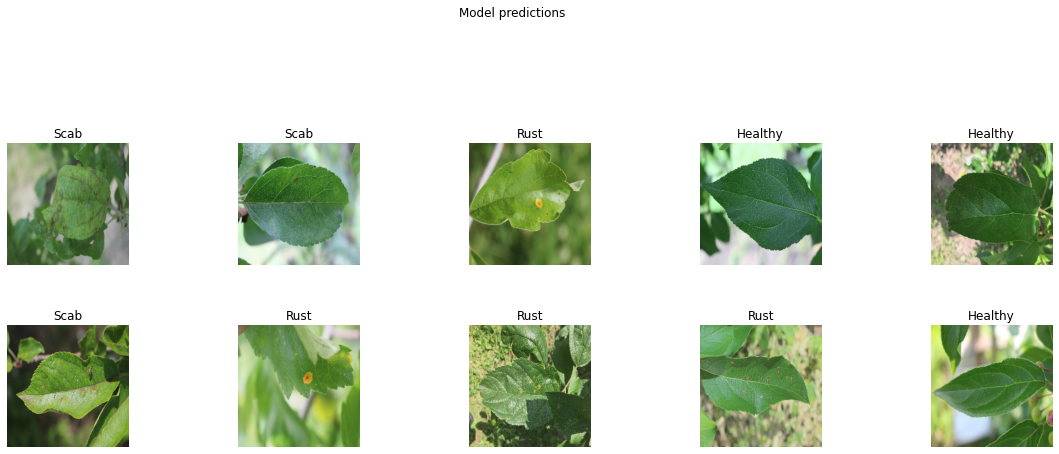

In [ ]:
plt.figure(figsize=(20,19))
plt.subplots_adjust(hspace=0.5)
for n in range(10):
  plt.subplot(6,5,n+1)
  if not NORMALIZE:
    plt.imshow(tf.cast(image_batch[n], dtype=tf.uint64))
  else:
    plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 112, 112, 32) 896         input_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 112, 112, 32) 128         conv2d_44[0][0]                  
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 112, 112, 32) 0           batch_normalization_44[0][0]     
____________________________________________________________________________________________

In [ ]:
model.save(base_area_path + '/keras_retrain_conv2d_FINAL_FINAL')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/data/disease/keras_retrain_conv2d_FINAL_FINAL/assets


In [ ]:
model.save(base_area_path + '/keras_retrain_conv2d_h5_FINAL_FINAL/mymodel.h5')

In [ ]:
tfjs.converters.save_keras_model(model, base_area_path + '/keras_retrain_conv2d_FINAL_FINAL_converted')

# 

# Convert model to tfjs

In [ ]:
model_path = '/content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/data/disease/imagenet'

loaded_model = tf.keras.models.load_model(model_path)

save_path = '/content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/data/disease/tf_js'



NameError: ignored

In [ ]:
def convert_model_to_tfj(model, save_path):
  tfjs.converters.save_keras_model(model, save_path)

In [ ]:
loaded_model

In [ ]:
convert_model_to_tfj(loaded_model, save_path)

In [ ]:
tfjs.converters.save_keras_model(loaded_model, '/content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/data/disease/imagenet_nonkeras')